In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports and loading training data



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
from queue import Queue
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from IPython.display import SVG
from tensorflow.data import Dataset
from IPython.display import display
import PIL

There is dataset folders

In [ ]:
training_dataset_images_path = '/content/drive/MyDrive/CVPR/car-object-detection/data/training_images'
testing_dataset_images_path = '/content/drive/MyDrive/CVPR/car-object-detection/data/testing_images'

In [ ]:
boxes_df = pd.read_csv('/content/drive/MyDrive/CVPR/car-object-detection/data/train_solution_bounding_boxes (1).csv')
boxes_df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764800  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020261  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

### Definitions


In [ ]:
def single_inputs(img_arr):
    x,y,z = img_arr.shape
    return img_arr.reshape((1,x,y,z))

In [ ]:
class DetectionBox:
    def __init__(self,x_min,y_min,x_max,y_max):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
    
    @staticmethod
    def from_named_tuple(tup):
        return DetectionBox(tup.xmin,tup.ymin,tup.xmax,tup.ymax)
    
    def scale(self,scale_mul):
        return DetectionBox(
            self.x_min * scale_mul,
            self.y_min * scale_mul,
            self.x_max * scale_mul,
            self.y_max * scale_mul
        )
    
    def resize_to_point(self,x,y):
        if self.x_min > x:
            self.x_min = x
        if self.x_max < x:
            self.x_max = x
        if self.y_min > y:
            self.y_min = y
        if self.y_max < y:
            self.y_max = y

class TrainingCase:
    def __init__(self,img_path):
        self.img_path = img_path
        self.boxes = []
    
    def add_box(self,tup):
        self.boxes.append(DetectionBox.from_named_tuple(tup))
    
    def get_image(self):
        img = load_img(self.img_path)
        img_arr = img_to_array(img)
        return img_arr
    
    def draw_image_with_boxes(self):
        img = load_img(self.img_path)
        img_arr = img_to_array(img)
        h,w = img_arr.shape[:2]
        
        def point(y,x,color):
            x = int(x)
            y = int(y)
            if x >= 0 and x < w and y >= 0 and y < h:
                img_arr[y,x,:] = color
        
        for box in self.boxes:
            if box.x_min-1 >= 0:
                for y in range(int(box.y_min),int(box.y_max)):
                    point(y, box.x_min-1,(0,255,0))
                    point(y, box.x_min  ,(0,255,0))
                    point(y, box.x_min+1,(0,255,0))
                    point(y, box.x_max-1,(0,255,0))
                    point(y, box.x_max  ,(0,255,0))
                    point(y, box.x_max+1,(0,255,0))
                for x in range(int(box.x_min),int(box.x_max)):
                    point(box.y_min-1, x,(0,255,0))
                    point(box.y_min  , x,(0,255,0))
                    point(box.y_min+1, x,(0,255,0))
                    point(box.y_max-1, x,(0,255,0))
                    point(box.y_max  , x,(0,255,0))
                    point(box.y_max+1, x,(0,255,0))
        
        img = PIL.Image.fromarray(img_arr.astype(np.uint8),'RGB')
        display(img)
    
    def get_answer(self):
        img = load_img(self.img_path)
        img_w, img_h = img.size
        
        h,w = int(img_h/32),int(img_w/32)
        out_arr = np.concatenate((np.full((1,h,w,1),-1,dtype=np.float),np.ones((1,h,w,1),dtype=np.float)),axis=3)
        
        
        for box in self.boxes:
            x_min,y_min,x_max,y_max = int(box.x_min / 32),int(box.y_min / 32),int(box.x_max / 32),int(box.y_max / 32)
            for y in range(y_min,y_max):
                for x in range(x_min,x_max):
                    if y < 0 or x < 0 or y >= h or x >= w:
                        continue
                    
                    out_arr[0,y,x,0] = 1
                    out_arr[0,y,x,1] = -1
        
        return out_arr
    
    def get_answer_as_outputs(self):
        answer = self.get_answer()
        return answer[0,:,:,0],answer[0,:,:,1]
    
    def get_inputs(self):
        return single_inputs(self.get_image())

In [ ]:
class KerasModelWrapper:
    def __init__(self,model):
        self._model = model
    
    @staticmethod
    def _normalize(matrix,min_val,max_val):
        return (matrix - min_val) / (max_val - min_val)
    
    def predict(self,case):
        inputs = case.get_inputs()
        results = self._model.predict(inputs)
        
        outs1 = results[0,:,:,0]
        outs2 = results[0,:,:,1]
        
        min_val = min(outs1.min(),outs2.min())
        max_val = min(outs1.max(),outs2.max())
        
        n_outs1 = KerasModelWrapper._normalize(outs1,min_val,max_val)
        n_outs2 = KerasModelWrapper._normalize(outs2,min_val,max_val)
        
        return outs1,outs2,(n_outs1 > n_outs2)
    
    def __call__(self,case):
        return self.predict(case)

In [ ]:
def df_to_training_list(df):
    trn_dict = dict()

    for i in boxes_df.itertuples():
        if not i.image in trn_dict:
            trn_case = TrainingCase(training_dataset_images_path + '/' + i.image)
            trn_dict[i.image] = trn_case
        else:
            trn_case = trn_dict[i.image]
        trn_case.add_box(i)

    trn_list = [val for (key,val) in trn_dict.items()]

    return trn_list

In [ ]:
def draw_outputs(outputs):
    for out in outputs:
        out = out * 1 # This operation should case boolean matrix to numeric.
        min_val = out.min()
        max_val = out.max()
        out = (out - min_val) / (max_val - min_val)
        img = PIL.Image.fromarray((out*255).astype(np.uint8),'L')
        w,h = img.size
        img = img.resize((w*4,h*4))
        display(img)

### Data preparation


In [ ]:
training_list = df_to_training_list(boxes_df)

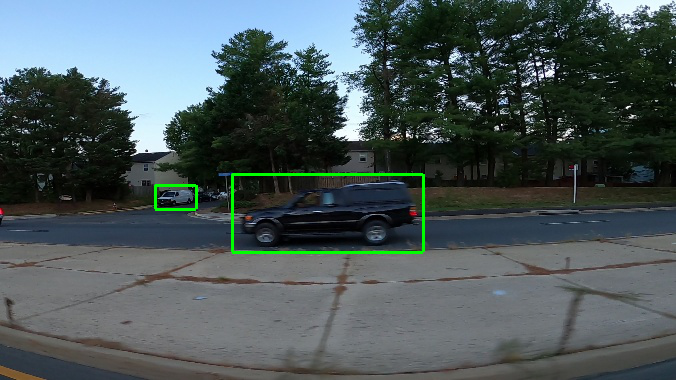

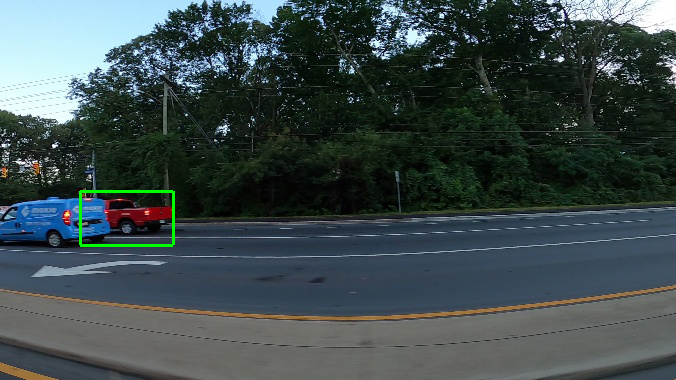

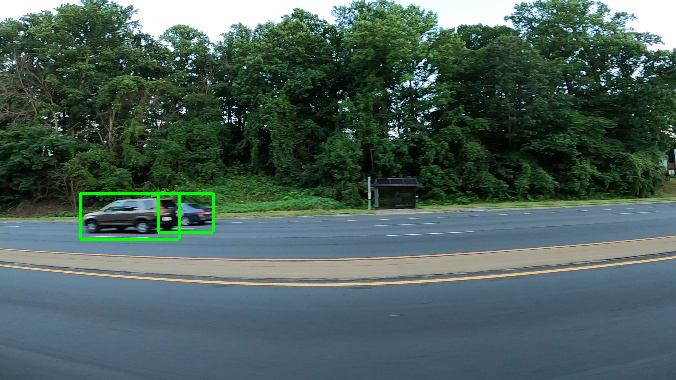

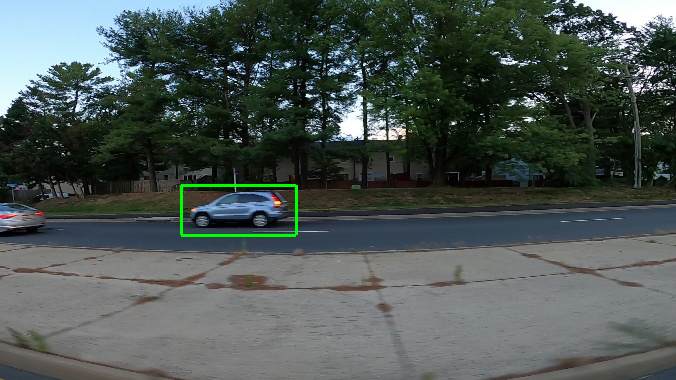

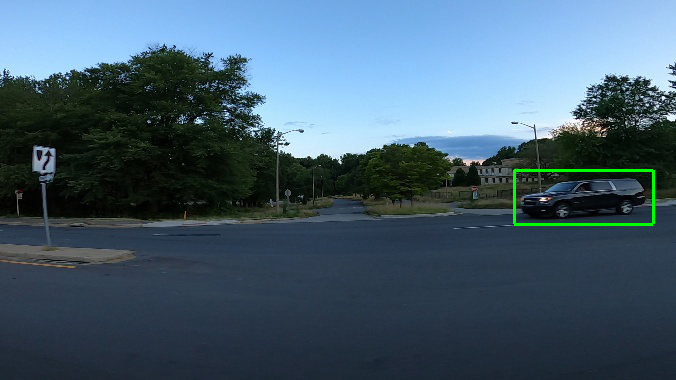

In [ ]:
for i in range(5):
    idx = random.randrange(len(training_list))
    training_list[idx].draw_image_with_boxes()

In [ ]:
train_X = np.concatenate([x.get_inputs() for x in training_list],axis=0)
train_y = np.concatenate([x.get_answer() for x in training_list],axis=0)

### Model definition and training

I will MobileNet architecture with additional convolution layer which split data to 2 classes - car and background. Pretrained layers not locked because experiments show me better quality of fitting.

In [ ]:
def build_model(input_shape, n_classes):
  
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
    
  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model


input_shape = (170, 170, 3)
num_classes = 1000
model = mobilenet(input_shape, num_classes)
model.summary()

In [ ]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 170, 170, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 85, 85, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 85, 85, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 85, 85, 32)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 85, 85, 32)       320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 85, 85, 32)       128   

In [ ]:
model.fit(train_X,train_y,epochs=100)

Epoch 1/100
12/12 [==============================] - 9s 766ms/step - loss: 1.3547
Epoch 2/100
12/12 [==============================] - 9s 768ms/step - loss: 0.1792
Epoch 3/100
12/12 [==============================] - 9s 767ms/step - loss: 0.0922
Epoch 4/100
12/12 [==============================] - 9s 752ms/step - loss: 0.0638
Epoch 5/100
12/12 [==============================] - 9s 756ms/step - loss: 0.0514
Epoch 6/100
12/12 [==============================] - 9s 764ms/step - loss: 0.0410
Epoch 7/100
12/12 [==============================] - 9s 755ms/step - loss: 0.0326
Epoch 8/100
12/12 [==============================] - 9s 762ms/step - loss: 0.0272
Epoch 9/100
12/12 [==============================] - 10s 802ms/step - loss: 0.0255
Epoch 10/100
12/12 [==============================] - 9s 773ms/step - loss: 0.0215
Epoch 11/100
12/12 [==============================] - 9s 776ms/step - loss: 0.0202
Epoch 12/100
12/12 [==============================] - 9s 768ms/step - loss: 0.0153
Epoch 13/100

Let's export our model.

In [ ]:
model.save('object_detection')

In [ ]:
!zip -r object_detection.zip object_detection
!rm -rv object_detection

In [ ]:
model_wrapper = KerasModelWrapper(model)

### Case and neural network inputs and outputs

Below 2 output channels which should predict our neural network according to random case from training dataset.

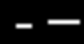

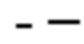

In [ ]:
random_case = training_list[random.randrange(len(training_list))]
draw_outputs(random_case.get_answer_as_outputs())

It is actual predictions and restored mask of detected objects

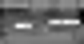

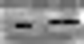

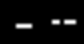

In [ ]:
draw_outputs(model_wrapper.predict(random_case))

### Checking on test data


In [ ]:
def load_test_images(path):
    cases = []
    for filename in os.listdir(path):
        file_path = path + '/' + filename
        case = TrainingCase(file_path)
        cases.append(case)
    
    return cases

In [ ]:
def populate_boxes(model,case):
    prediction = model.predict(case)
    mask = prediction[2].copy()
    h,w = mask.shape
    boxes = []
    
    def walk_on_box(sx,sy):
        box = DetectionBox(sx,sy,sx,sy)
        q = Queue()
        q.put((sx,sy))
        while not q.empty():
            x,y = q.get()
            box.resize_to_point(x+1,y+1)
            mask[y,x] = False
            if y+1 < h and mask[y+1,x]:
                q.put((x,y+1))
            if y-1 >= 0 and mask[y-1,x]:
                q.put((x,y-1))
            if x+1 < w and mask[y,x+1]:
                q.put((x+1,y))
            if x-1 >= 0 and mask[y,x-1]:
                q.put((x-1,y))
        
        return box.scale(32)
    
    for y in range(h):
        for x in range(w):
            if mask[y,x]:
                boxes.append(walk_on_box(x,y))
    
    case.boxes = boxes

Fill boxes lists using prediction from neural network

In [ ]:
testing_list = load_test_images(testing_dataset_images_path)
for case in testing_list:
    populate_boxes(model_wrapper,case)

Some random examples of testing images and predicted boxes.

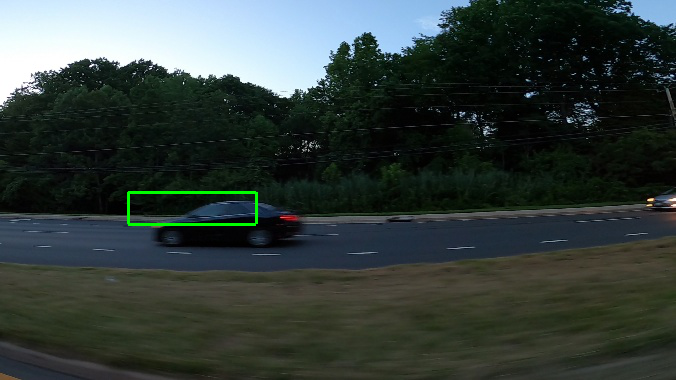

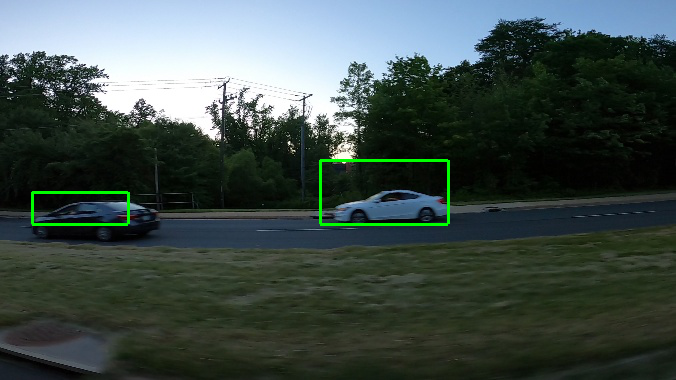

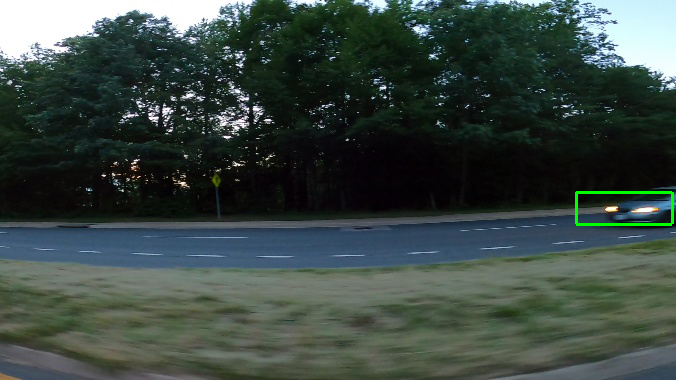

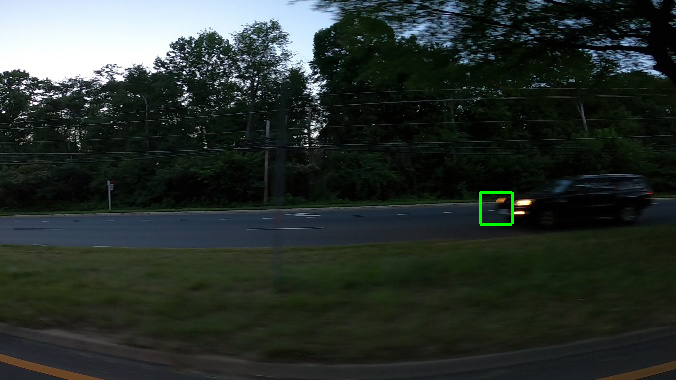

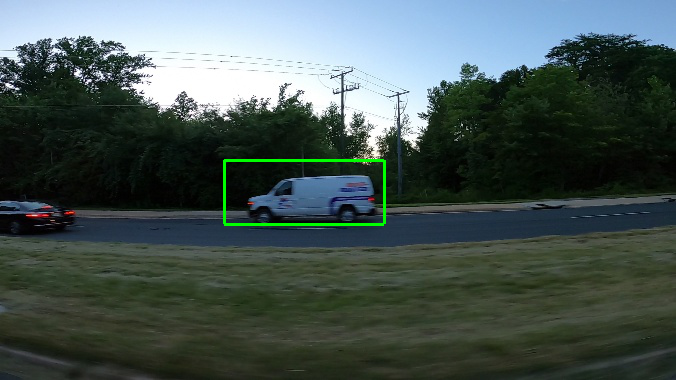

In [ ]:
for i in range(5):
    idx = random.randrange(len(testing_list))
    while len(testing_list[idx].boxes) == 0:
        idx = random.randrange(len(testing_list))
    testing_list[idx].draw_image_with_boxes()

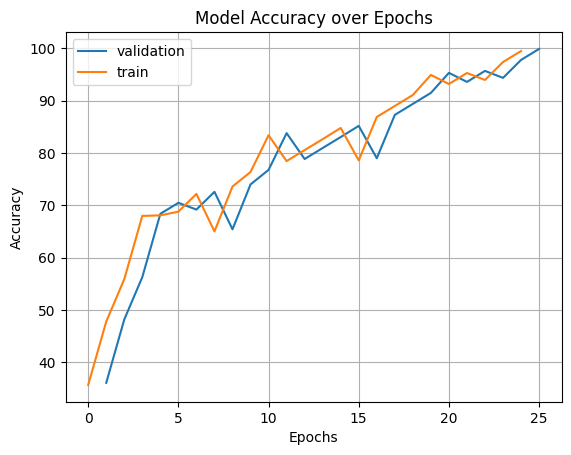

In [34]:
plt.figure(figsize=(10,7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

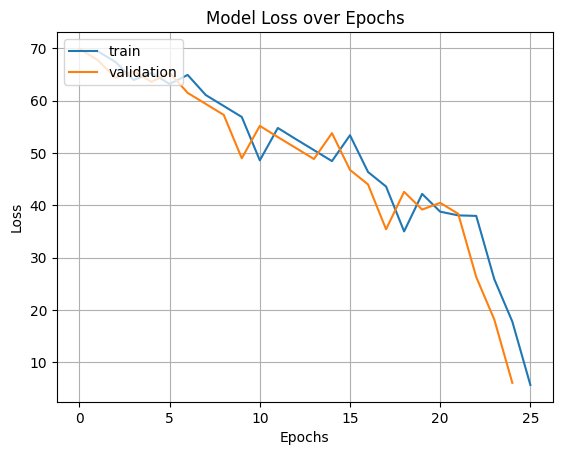

In [43]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()